In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig

In [3]:
from childes_mi.information_theory import model_fitting as mf

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

<ipython-input-4-d3dd355f8edb>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
### get proportion info

In [6]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR, FIGURE_DIR


In [7]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df_all_participants.pickle')
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [8]:
prop_df = pd.DataFrame(columns = ['transcript_id', 'child_phones', 'total_phones', 'prop_phones'])
for tid in tqdm(np.unique(phone_df.transcript_id.values)):
    transcript_df_subset = phone_df[phone_df.transcript_id == tid]
    child_phones = transcript_df_subset[transcript_df_subset.role.isin(['Target Child'])].n_phones.sum()
    total_phones = transcript_df_subset.n_phones.sum()
    prop_df.loc[len(prop_df)] = [
        tid, child_phones, total_phones, child_phones/total_phones
    ]

prop_df[:3]

  0%|          | 0/697 [00:00<?, ?it/s]

,transcript_id,child_phones,total_phones,prop_phones
0,000314,41,41,1.0
1,000610,14,14,1.0
2,000611,38,38,1.0


### Get MI

In [9]:
MI_DF = pd.read_pickle(DATA_DIR/'mi/phonbank_all_indv_seqs.pickle')

In [10]:
len(MI_DF)

668

In [11]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,age,dataset,xml_loc,n_phones,transcript_id,phones_list
0,"[4.356248338413511, 4.047189090769368, 3.92068...","[0.051951813332510775, 0.05127182251496144, 0....","[3.602903551230197, 3.6005794590353837, 3.6043...","[0.050980135620703027, 0.05097211442089026, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2751,1,1.000,Providence,/mnt/cube/tsainbur/Projects/github_repos/LRSO_...,669,001126,aɪaɛːaːʌʌaːaːoaʌʌʌaaoʷəoʷəoʷəaːwuaːaːoʷəʌʌʌnəo...
1,"[4.477608516941267, 4.1993657535591264, 3.9954...","[0.05858440505243816, 0.058077478756595045, 0....","[3.5764786125510426, 3.5830033856535106, 3.585...","[0.05649948441070945, 0.05645350178285826, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2747,1,1.000,Providence,/mnt/cube/tsainbur/Projects/github_repos/LRSO_...,574,010014,ɛwauʊxdaːnɪʊinʊhʊmɔːbɪhəmʌænænənænænəkæaʔmamam...
2,"[4.066396779927116, 4.034615560966813, 3.74323...","[0.06117625630338075, 0.06011312327007976, 0.0...","[3.474562089813773, 3.4893603574233776, 3.4778...","[0.0593948160025596, 0.059378692862158494, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,1920,1,0.833,Davis,/mnt/cube/tsainbur/Projects/github_repos/LRSO_...,500,001007,ədɛˈdəgɛadɪddɛæədɪədaːdadaˈdavːbaːbabaˈdæːdæːg...


In [12]:
MI_DF.age_cohort_low.unique()

array([0.5, 1. , 1.5, 2. , 2.5, 3. ])

In [13]:
age_cohorts = [[0.5, 1],[1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [14]:
MI_DF_list = []
for [ac_low, ac_high] in age_cohorts:
    MI_DF_list.append(MI_DF[MI_DF.age_cohort_low == ac_low])
MI_DF = pd.concat(MI_DF_list)

In [15]:
len(MI_DF)

668

In [16]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [17]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    dist_mask = distances < 100
    distances = distances[dist_mask]
    sig = sig[dist_mask]
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        if len(peaks[0]) > 0:
            min_peak = peaks[0][0]
        else: 
            min_peak = np.nan
    else:
        min_peak = np.nan
    
    
    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]

  0%|          | 0/668 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/childes-paper/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/mnt/cube/tsainbur/Projects/github_repos/LRSO_paper_rev/LongRangeSequentialOrgPaper/childes_mi/information_theory/model_fitting.py:8: RuntimeWarning: invalid value encountered in log
  return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))
/mnt/cube/tsainbur/Projects/github_repos/LRSO_paper_rev/LongRangeSequentialOrgPaper/childes_mi/information_theory/model_fitting.py:8: RuntimeWarning: divide by zero encountered in log
  return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))


In [18]:
len(peaks[0])

2

In [19]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,age,...,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[4.356248338413511, 4.047189090769368, 3.92068...","[0.051951813332510775, 0.05127182251496144, 0....","[3.602903551230197, 3.6005794590353837, 3.6043...","[0.050980135620703027, 0.05097211442089026, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2751,1,1.000,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.968157,0.987396,0.987116,-537.028946,-624.386718,-626.608892,pow,"[5.98115412577245e-07, 8.982795546691827e-07, ...",NaN
1,"[4.477608516941267, 4.1993657535591264, 3.9954...","[0.05858440505243816, 0.058077478756595045, 0....","[3.5764786125510426, 3.5830033856535106, 3.585...","[0.05649948441070945, 0.05645350178285826, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2747,1,1.000,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.948680,0.977398,0.974078,-434.590507,-511.384401,-502.207791,pow_exp,"[-3.08616733160039e-06, -4.6370115276130916e-0...",197.0
2,"[4.066396779927116, 4.034615560966813, 3.74323...","[0.06117625630338075, 0.06011312327007976, 0.0...","[3.474562089813773, 3.4893603574233776, 3.4778...","[0.0593948160025596, 0.059378692862158494, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,1920,1,0.833,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.962287,0.962287,0.940493,-576.237650,-571.845120,-531.085645,exp,"[-3.5375261332526604e-06, -5.312784623313265e-...",NaN


In [20]:
MI_DF_pid = MI_DF.merge(prop_df)

In [21]:
%matplotlib inline

In [22]:
MI_DF_pid.n_phones

,n_phones,n_phones
0,2751,669
1,2747,574
2,1920,500
3,1508,429
4,1653,426
...,...,...
663,2730,710
664,2360,642
665,2356,621
666,2094,573


In [23]:
MI_DF_pid = MI_DF_pid[MI_DF_pid.concat_results.isnull() == False]

In [25]:
MI_DF_pid.to_pickle(DATA_DIR/'mi/phone_df_all_participants_fit.pickle')

In [26]:
for idx, row in MI_DF_pid.iterrows():
    row.concat_results.params['e_init'].value

In [27]:
MI_DF_pid['e_init'] = [row.concat_results.params['e_init'].value for idx, row in MI_DF_pid.iterrows()]
MI_DF_pid['e_decay_const'] = [row.concat_results.params['e_decay_const'].value for idx, row in MI_DF_pid.iterrows()]
MI_DF_pid['p_init'] = [row.concat_results.params['p_init'].value for idx, row in MI_DF_pid.iterrows()]
MI_DF_pid['p_decay_const'] = [row.concat_results.params['p_decay_const'].value for idx, row in MI_DF_pid.iterrows()]
MI_DF_pid['intercept'] = [row.concat_results.params['intercept'].value for idx, row in MI_DF_pid.iterrows()]

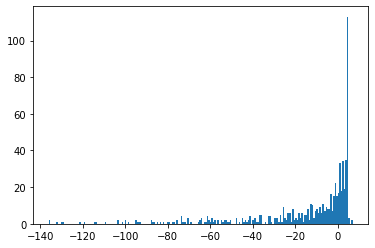

In [28]:
plt.hist(np.array(MI_DF.AICc_concat - MI_DF.AICc_exp), bins = 200);

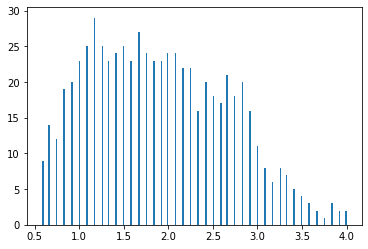

In [29]:
plt.hist(np.array(MI_DF_pid.age), bins = 200);

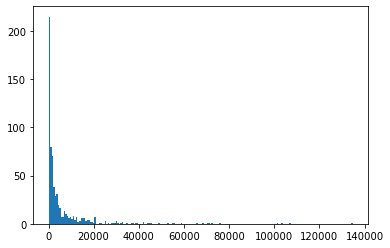

In [30]:
plt.hist(np.array(MI_DF_pid.child_phones), bins = 200);

In [31]:
import seaborn as sns

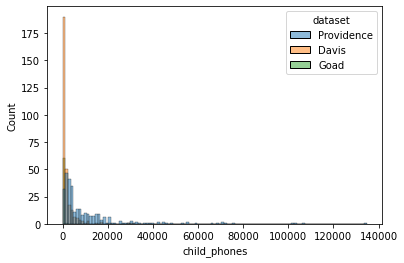

In [32]:
fig, ax = plt.subplots()
sns.histplot(MI_DF_pid, x = 'child_phones', hue = "dataset", ax = ax);

In [33]:
MI_DF_pid['delta_aic'] = np.min([MI_DF_pid['AICc_concat'], MI_DF_pid['AICc_power']],axis=0) -  MI_DF_pid['AICc_exp']

In [34]:
MI_DF_pid['delta_aic'] = MI_DF_pid['AICc_concat'] -  MI_DF_pid['AICc_exp']

In [36]:
MI_DF_pid['log_child_phones'] = np.log(MI_DF_pid.child_phones.values.astype(float))

In [37]:
MI_DF_pid['log_delta_aic'] = np.log(1+np.max(MI_DF_pid.delta_aic)-np.array(MI_DF_pid.delta_aic))

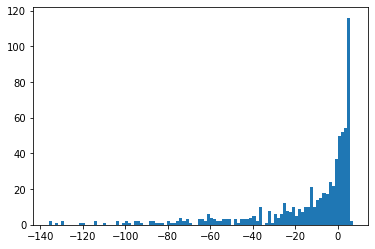

In [38]:
plt.hist(MI_DF_pid['delta_aic'].values, bins=100);

In [39]:
c = MI_DF.dataset.values
pal = sns.color_palette('Set1', len(np.unique(c)))
pal_dict = {i:p for i, p in zip(np.unique(c), pal)}
c_list = [pal_dict[i] for i in c]
np.unique(c)

array(['Davis', 'Goad', 'Providence'], dtype=object)

In [40]:
pal

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726)]

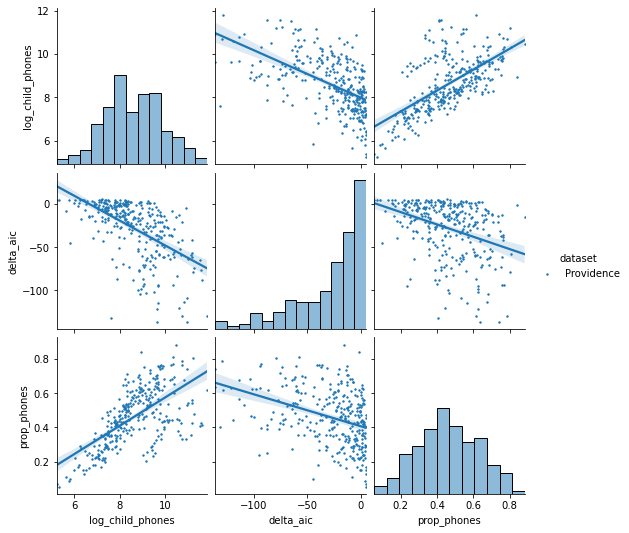

In [41]:
g = sns.pairplot(
    MI_DF_pid[MI_DF_pid.prop_phones < 1][
        ["log_child_phones", "delta_aic", "prop_phones", "dataset"] # "age"
    ],
    hue = 'dataset',
    kind="reg",
    plot_kws={"scatter_kws":{"s": 2, "alpha": 1}},
    diag_kind="hist",
)

In [42]:
from scipy.stats import pearsonr

(0.04564374436636429, 0.23875715129493086)


Text(0.5, 0, '# phones')

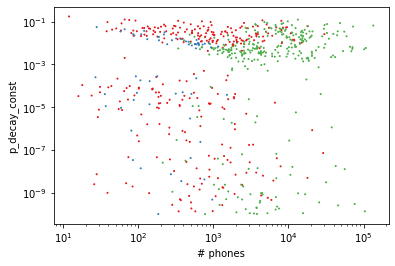

In [43]:
fig, ax = plt.subplots()
x = np.array(MI_DF_pid.child_phones.values).astype(float)
y = np.array(MI_DF_pid.intercept)
print(pearsonr(x,y))
ax.scatter(x, y, s=1, alpha = 1, c = c_list);
#ax.set_ylim([-10,10])
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('p_decay_const')
ax.set_xlabel('# phones')

In [44]:
MI_DF_pid.n_phones

,n_phones,n_phones
0,2751,669
1,2747,574
2,1920,500
3,1508,429
4,1653,426
...,...,...
663,2730,710
664,2360,642
665,2356,621
666,2094,573


(0.743334889695168, 2.0763516158205983e-118)


Text(0.5, 0, '# words')

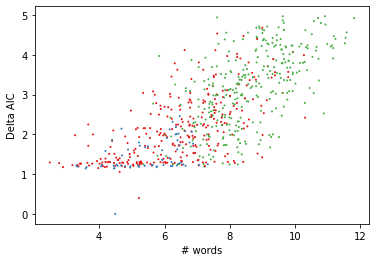

In [45]:
fig, ax = plt.subplots()
x = np.log(np.array(MI_DF_pid.child_phones.values).astype(float))
y = np.log(1+np.max(MI_DF_pid.delta_aic)-np.array(MI_DF_pid.delta_aic))
print(pearsonr(x,y))
ax.scatter(x, y, s=1, alpha = 1, c = c_list);
#ax.set_ylim([-10,10])
#ax.set_xscale('log')
#ax.set_yscale('symlog')

ax.set_ylabel('Delta AIC')
ax.set_xlabel('# words')

(-0.5610817537459316, 5.0432288257319e-27)


Text(0.5, 0, '# words')

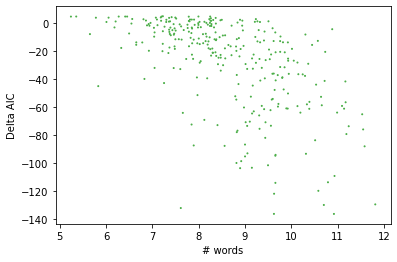

In [46]:
fig, ax = plt.subplots()
mask = MI_DF_pid.prop_phones < 1
x = np.log(np.array(MI_DF_pid[mask].child_phones.values).astype(float))
y = np.array(MI_DF_pid[mask].delta_aic)
print(pearsonr(x,y))
ax.scatter(x, y, s=1, alpha = 1,c = np.array(c_list)[mask]);
#ax.set_ylim([-10,10])
#ax.set_xscale('log')
#ax.set_yscale('symlog')

ax.set_ylabel('Delta AIC')
ax.set_xlabel('# words')

(-0.4975197948784889, 9.965144126254383e-21)


Text(0.5, 0, '# words')

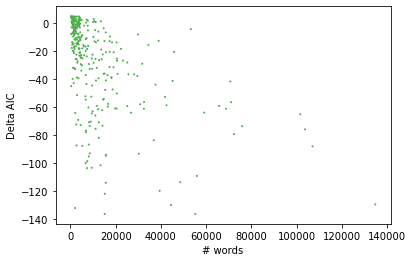

In [47]:
fig, ax = plt.subplots()
mask = MI_DF_pid.prop_phones < 1
x = np.array(MI_DF_pid[mask].child_phones.values).astype(float)
y = np.array(MI_DF_pid[mask].delta_aic)
print(pearsonr(x,y))
ax.scatter(x, y, s=1, alpha = 1,c = np.array(c_list)[mask]);
#ax.set_ylim([-10,10])
#ax.set_xscale('log')
#ax.set_yscale('symlog')

ax.set_ylabel('Delta AIC')
ax.set_xlabel('# words')

(0.2964590683472205, 1.096263045222406e-07)


Text(0.5, 0, 'Age')

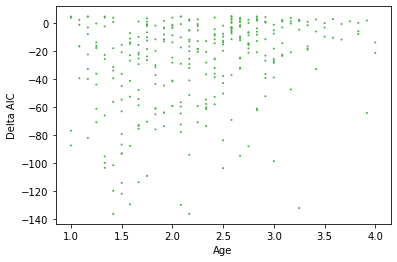

In [48]:
fig, ax = plt.subplots()
mask = MI_DF_pid.prop_phones < 1
x = np.array(MI_DF_pid[mask].age.values).astype(float)
y = np.array(MI_DF_pid[mask].delta_aic)
print(pearsonr(x,y))
ax.scatter(x, y, s=1, alpha = 1,c = np.array(c_list)[mask]);
#ax.set_ylim([-10,10])
#ax.set_xscale('log')
#ax.set_yscale('symlog')

ax.set_ylabel('Delta AIC')
ax.set_xlabel('Age')

(-0.3628707672704944, 4.7551252955324324e-11)


Text(0.5, 0, 'Prop words by child')

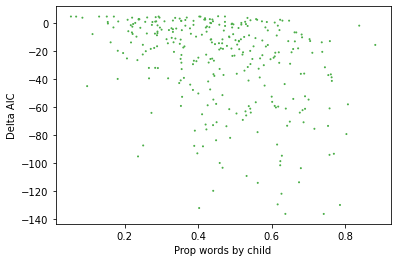

In [49]:
fig, ax = plt.subplots()
mask = MI_DF_pid.prop_phones < 1
x = np.array(MI_DF_pid[mask].prop_phones.values).astype(float)
y = np.array(MI_DF_pid[mask].delta_aic)
print(pearsonr(x,y))
ax.scatter(x, y, s=1, alpha = 1, c = np.array(c_list)[mask]);
#ax.set_ylim([-10,10])
#ax.set_xscale('log')
#ax.set_yscale('symlog')

ax.set_ylabel('Delta AIC')
ax.set_xlabel('Prop words by child')

(0.6333164158772636, 4.779229247728442e-36)


Text(0.5, 0, 'Prop words by child')

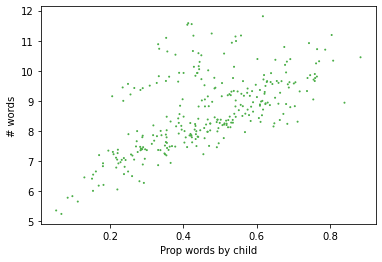

In [50]:
fig, ax = plt.subplots()
mask = MI_DF_pid.prop_phones < 1
x = np.array(MI_DF_pid[mask].prop_phones.values).astype(float)
y =np.array(MI_DF_pid[mask].log_child_phones.values)
print(pearsonr(x,y))
ax.scatter(x, y, s=1, alpha = 1, c = np.array(c_list)[mask]);
#ax.set_ylim([-10,10])
#ax.set_yscale('log')
#ax.set_yscale('symlog')

ax.set_ylabel('# words')
ax.set_xlabel('Prop words by child')

(-0.32291579386979374, 6.258024609707936e-09)


Text(0.5, 0, 'Prop words by child')

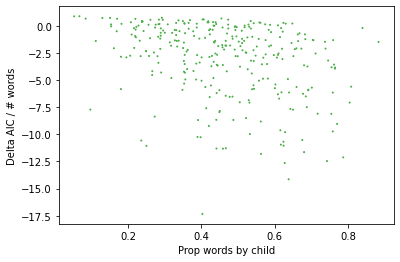

In [51]:
fig, ax = plt.subplots()
mask = MI_DF_pid.prop_phones < 1
x = np.array(MI_DF_pid[mask].prop_phones.values).astype(float)  
y = np.array(MI_DF_pid[mask].delta_aic)/ np.log(np.array(MI_DF_pid[mask].child_phones.values).astype(float))
print(pearsonr(x,y))
ax.scatter(x, y, s=1, alpha = 1, c = np.array(c_list)[mask]);
#ax.set_ylim([-10,10])
#ax.set_yscale('symlog')
ax.set_ylabel('Delta AIC / # words')
ax.set_xlabel('Prop words by child')

### model 

In [52]:
MI_DF_pid[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,age,...,total_phones,prop_phones,e_init,e_decay_const,p_init,p_decay_const,intercept,delta_aic,log_child_phones,log_delta_aic
0,"[4.356248338413511, 4.047189090769368, 3.92068...","[0.051951813332510775, 0.05127182251496144, 0....","[3.602903551230197, 3.6005794590353837, 3.6043...","[0.050980135620703027, 0.05097211442089026, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2751,1,1.000,...,10692,0.250281,0.203142,0.514978,5.802910e-01,-0.860633,5.210685e-02,-87.357772,7.892078,4.558598
1,"[4.477608516941267, 4.1993657535591264, 3.9954...","[0.05858440505243816, 0.058077478756595045, 0....","[3.5764786125510426, 3.5830033856535106, 3.585...","[0.05649948441070945, 0.05645350178285826, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2747,1,1.000,...,17613,0.391075,0.876177,0.507513,3.950469e-01,-0.576680,4.727396e-09,-76.793894,8.837536,4.441305
2,"[4.066396779927116, 4.034615560966813, 3.74323...","[0.06117625630338075, 0.06011312327007976, 0.0...","[3.474562089813773, 3.4893603574233776, 3.4778...","[0.0593948160025596, 0.059378692862158494, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,1920,1,0.833,...,4500,1.000000,0.784232,0.442820,4.232348e-09,-0.016570,1.138039e-01,4.392530,8.411833,1.308131


In [53]:
import re
def convert_age(age_year):
    "Caclculate age in months from a string in CHILDES format"
    if age_year[-1] == 'Y':
        age_year += '0'
    m = re.match("P(\d+)Y(\d+)M?(\d?\d?)D?", age_year)
    age_month = int(m.group(1)) * 12 + int(m.group(2))
    try:
        if int(m.group(3)) > 15:
            age_month += 1
    # some corpora don't have age information?
    except ValueError as e:
        pass
    return age_month

MI_DF_pid["age_months"] = [
    convert_age(i) if type(i) == str else np.nan for i in tqdm(MI_DF_pid.age.values)
]
MI_DF_pid["age_years"] = MI_DF_pid["age_months"] / 12

  0%|          | 0/668 [00:00<?, ?it/s]

In [54]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [55]:
MI_DF_pid['child_phones'] = MI_DF_pid['child_phones'].astype('float')

In [56]:
MI_DF_pid['log_child_phones'] = np.log(MI_DF_pid.child_phones)

In [57]:
MI_DF_pid['log_delta_aic'] = np.log(1+np.max(MI_DF_pid.delta_aic)-np.array(MI_DF_pid.delta_aic))

In [58]:
results = smf.ols('delta_aic ~ log_child_phones + dataset + age + prop_phones', data=MI_DF_pid[MI_DF_pid.prop_phones<1]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_aic   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     57.89
Date:                Sun, 28 Feb 2021   Prob (F-statistic):           1.19e-29
Time:                        22:29:25   Log-Likelihood:                -1442.1
No. Observations:                 309   AIC:                             2892.
Df Residuals:                     305   BIC:                             2907.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           64.0561     12.430  

In [59]:
base_model = smf.ols('delta_aic ~ log_child_phones + dataset + age', data=MI_DF_pid[MI_DF_pid.prop_phones<1]).fit()
full_model = smf.ols('delta_aic ~ log_child_phones + dataset + age + prop_phones', data=MI_DF_pid[MI_DF_pid.prop_phones<1]).fit()
anova_lm(base_model,full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,306.0,204924.983110,0.0,NaN,NaN,NaN
1,305.0,204786.975483,1.0,138.007627,0.205542,0.650607


In [60]:
results = smf.ols('log_delta_aic ~ log_child_phones + dataset + age + prop_phones', data=MI_DF_pid[MI_DF_pid.prop_phones<1]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          log_delta_aic   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     70.68
Date:                Sun, 28 Feb 2021   Prob (F-statistic):           9.97e-35
Time:                        22:29:26   Log-Likelihood:                -348.11
No. Observations:                 309   AIC:                             704.2
Df Residuals:                     305   BIC:                             719.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0435      0.360  

In [61]:
base_model = smf.ols('delta_aic ~ log_child_phones + dataset + age', data=MI_DF_pid[MI_DF_pid.prop_phones<1]).fit()
full_model = smf.ols('delta_aic ~ log_child_phones + dataset + age + prop_phones', data=MI_DF_pid[MI_DF_pid.prop_phones<1]).fit()
anova_lm(base_model,full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,306.0,204924.983110,0.0,NaN,NaN,NaN
1,305.0,204786.975483,1.0,138.007627,0.205542,0.650607


In [62]:
len(MI_DF_pid[MI_DF_pid.prop_phones<1])

309